In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

In [81]:
#Unet CLASICA (nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,32)
        self.Layer2Down = DownConv(32,64)
        self.Layer3Down = DownConv(64,128)
        self.Layer4Down = DownConv(128,256)
        self.Layer5Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        self.Layer5Up = UpConv(64+32,32)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(32,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        conv5 = self.Layer5Down(maxPool4)
        maxPool5 = self.MaxPool(conv5)
        
        middle = self.Middle(maxPool5)
        
        # Up
        up1= self.Layer1Up(middle,conv5)
        up2= self.Layer2Up(up1,conv4)
        up3= self.Layer3Up(up2,conv3)
        up4= self.Layer4Up(up3,conv2)
        up5= self.Layer5Up(up4,conv1)
        
        outUNet = self.Out(up5)
        
        return outUNet

unet = Unet()

In [3]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [4]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]


img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [5]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]

In [6]:
# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]

In [22]:
# Error cuadratico medio entre 2 imgs
def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] 
        error = suma / cantPix
        return error
    
def imshow(img, min=0, max=1):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),vmin = min, vmax = max)

In [80]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.expand_dims(inputs, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.expand_dims(gT, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')

img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

RuntimeError: Given groups=1, weight of size [256, 1024, 3, 3], expected input[1, 768, 16, 16] to have 1024 channels, but got 768 channels instead

In [9]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

In [78]:
# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

loss_values=[]

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    loss_values.append(avg_loss / (train_noisyImage.shape[0]))

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.expand_dims(vinputs, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.expand_dims(validGroundTruth, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:
  image 10 loss: 0.17774381935596467
LOSS train 0.17774381935596467 valid 0.1808805763721466
EPOCH 2:
  image 10 loss: 0.16873091757297515
LOSS train 0.16873091757297515 valid 0.17448729276657104
EPOCH 3:
  image 10 loss: 0.16119619756937026
LOSS train 0.16119619756937026 valid 0.16910672187805176
EPOCH 4:
  image 10 loss: 0.1545418068766594
LOSS train 0.1545418068766594 valid 0.1640957146883011
EPOCH 5:
  image 10 loss: 0.14871881008148194
LOSS train 0.14871881008148194 valid 0.1602211892604828


[1,     1] loss: 0.176


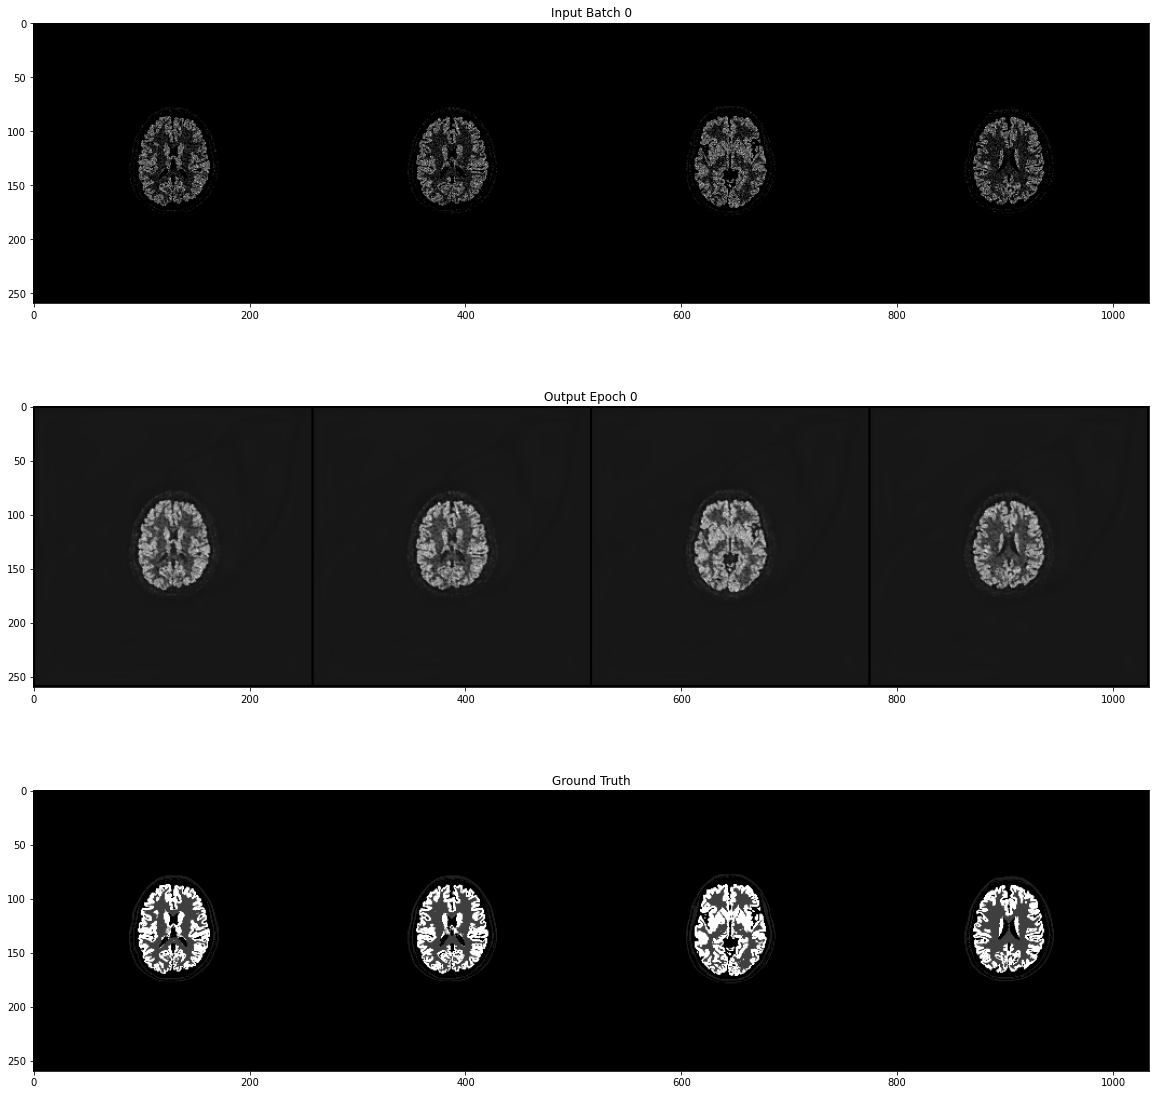

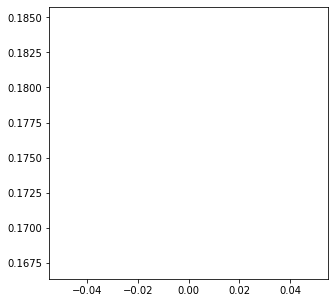

[1,     2] loss: 0.170


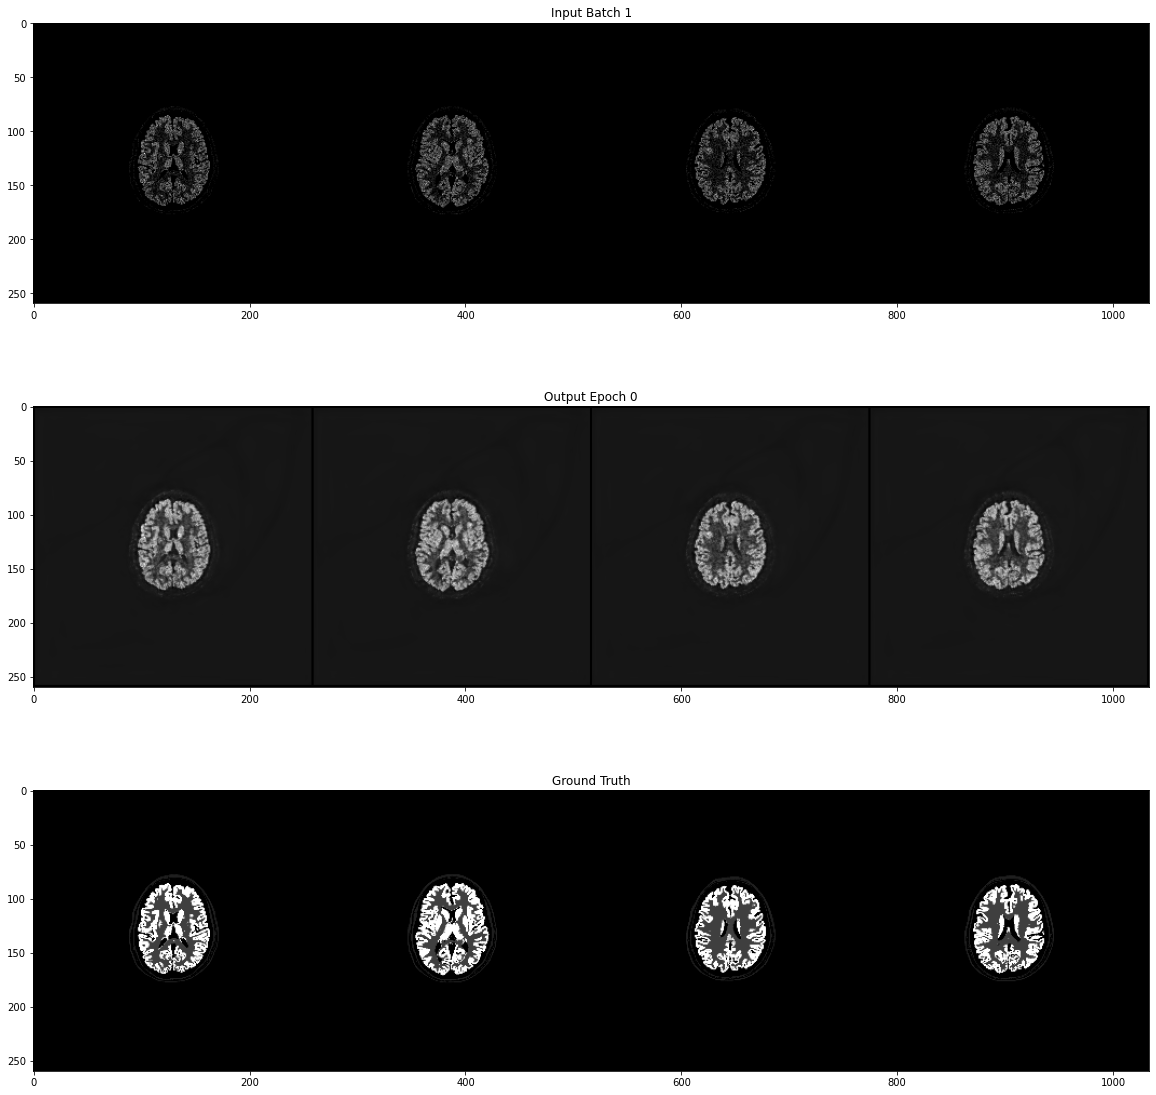

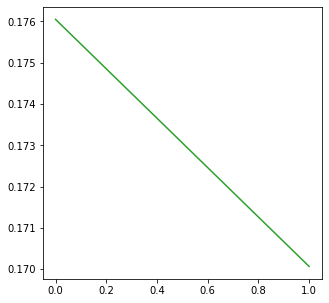

[1,     3] loss: 0.223


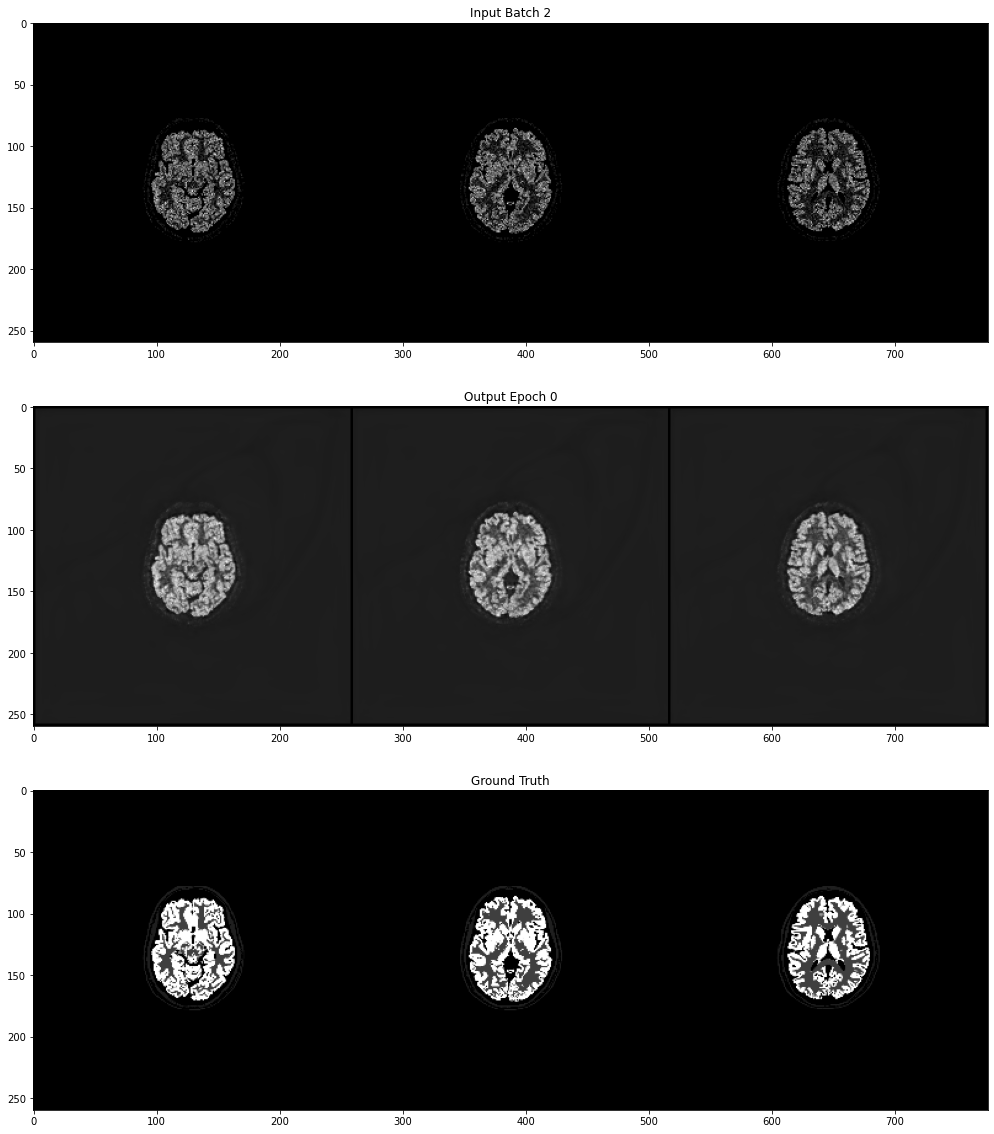

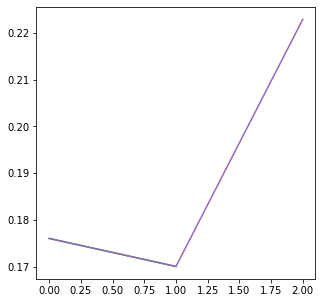

LOSS train 0.22285987436771393 valid 0.2023744285106659
[2,     1] loss: 0.172


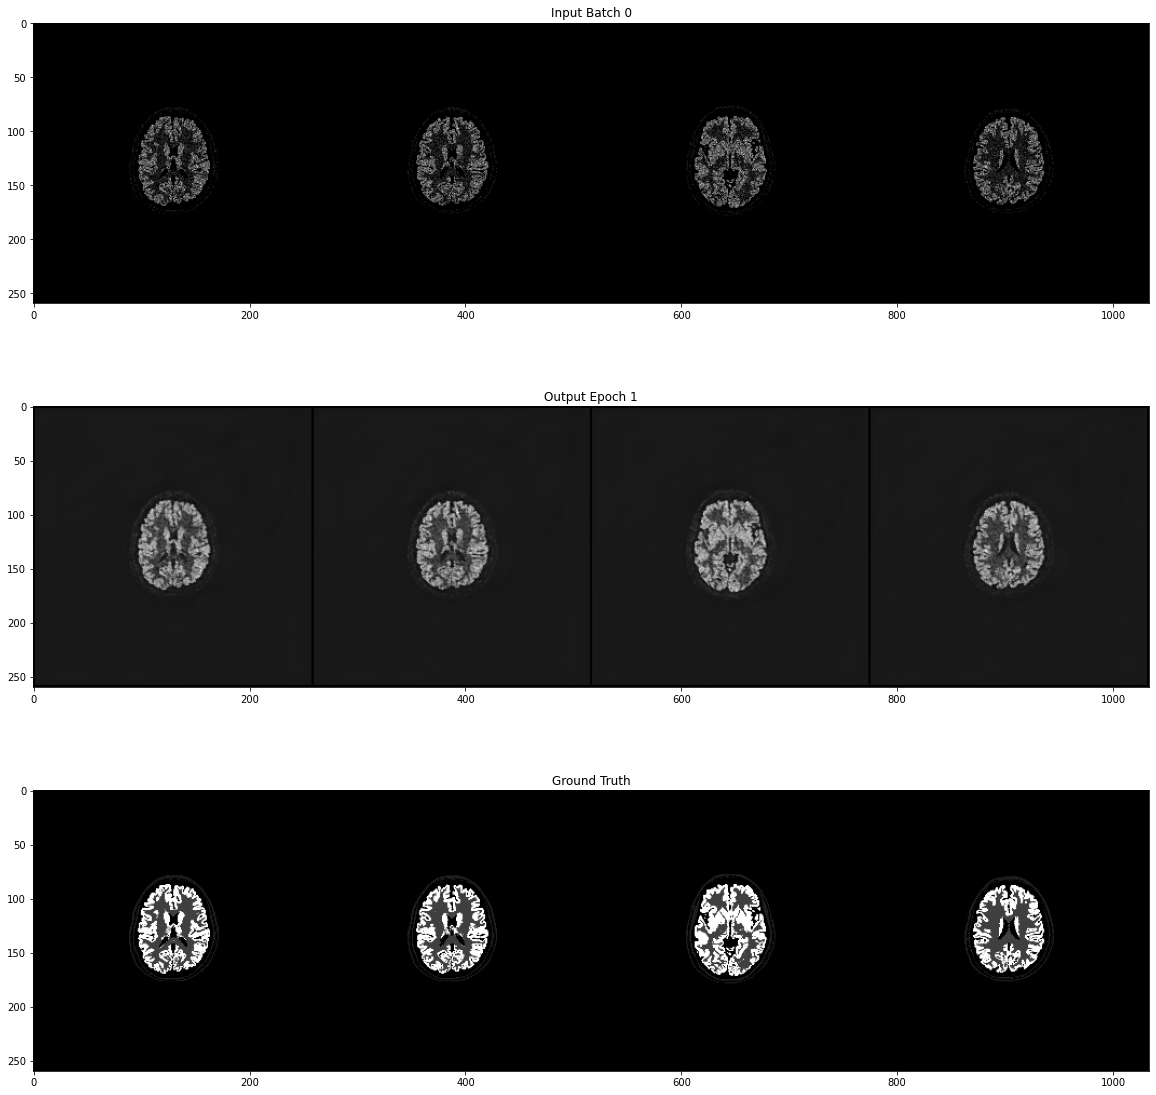

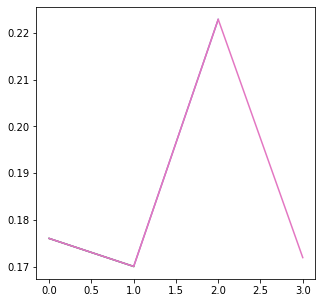

[2,     2] loss: 0.166


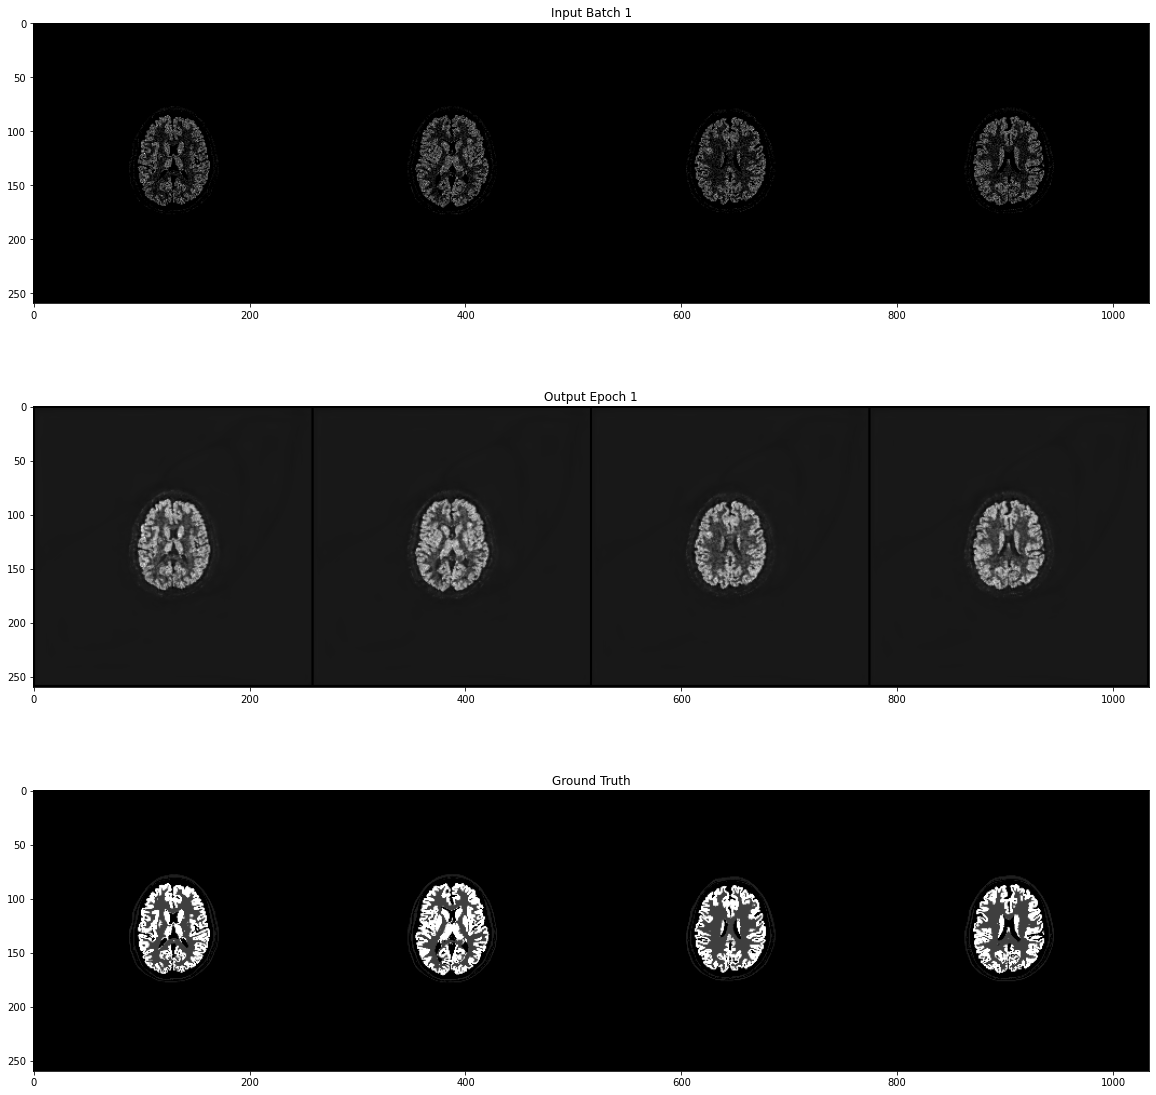

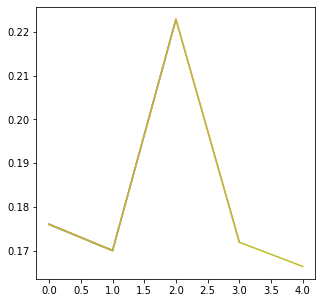

[2,     3] loss: 0.217


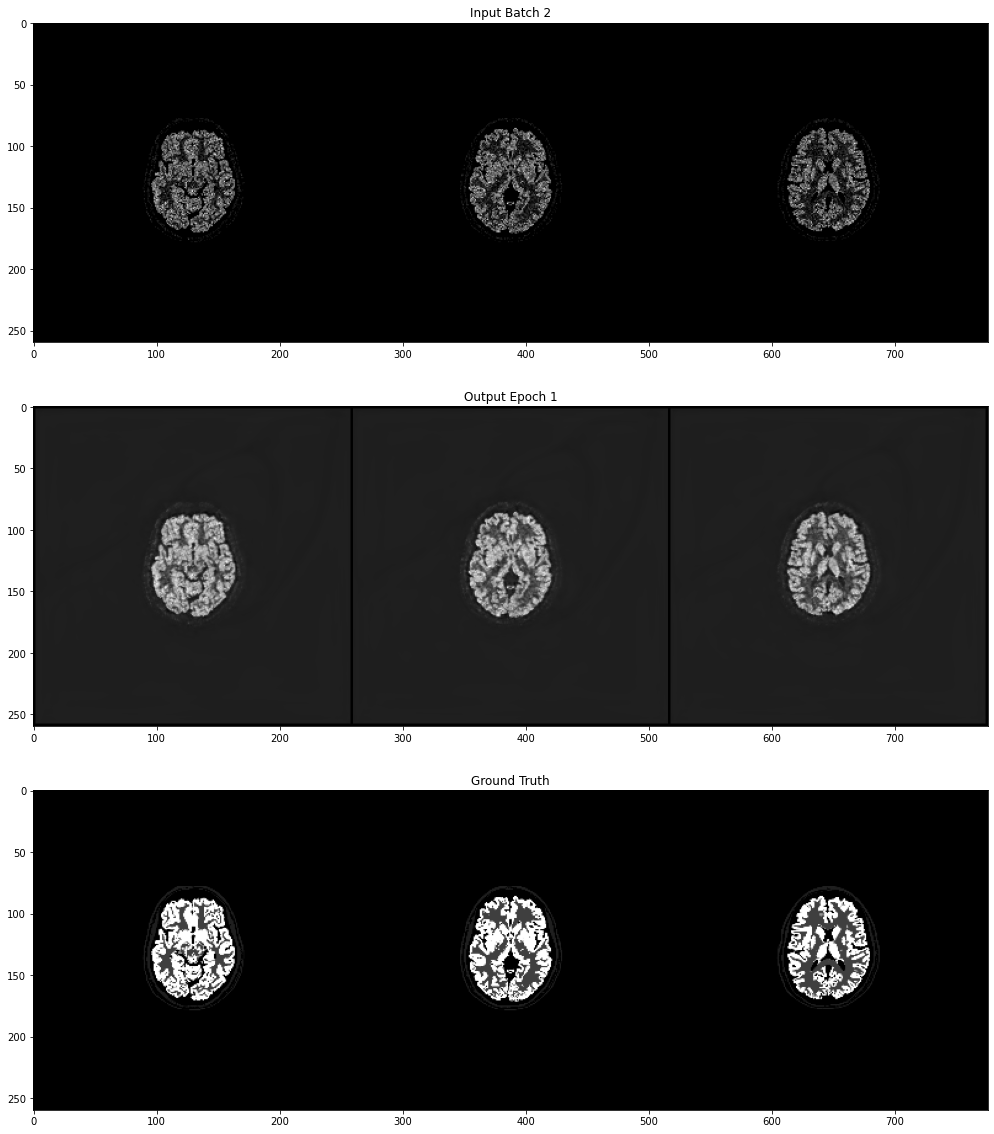

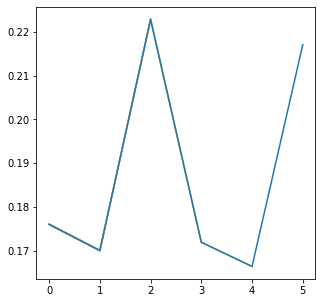

LOSS train 0.21708624064922333 valid 0.19673863053321838
[3,     1] loss: 0.169


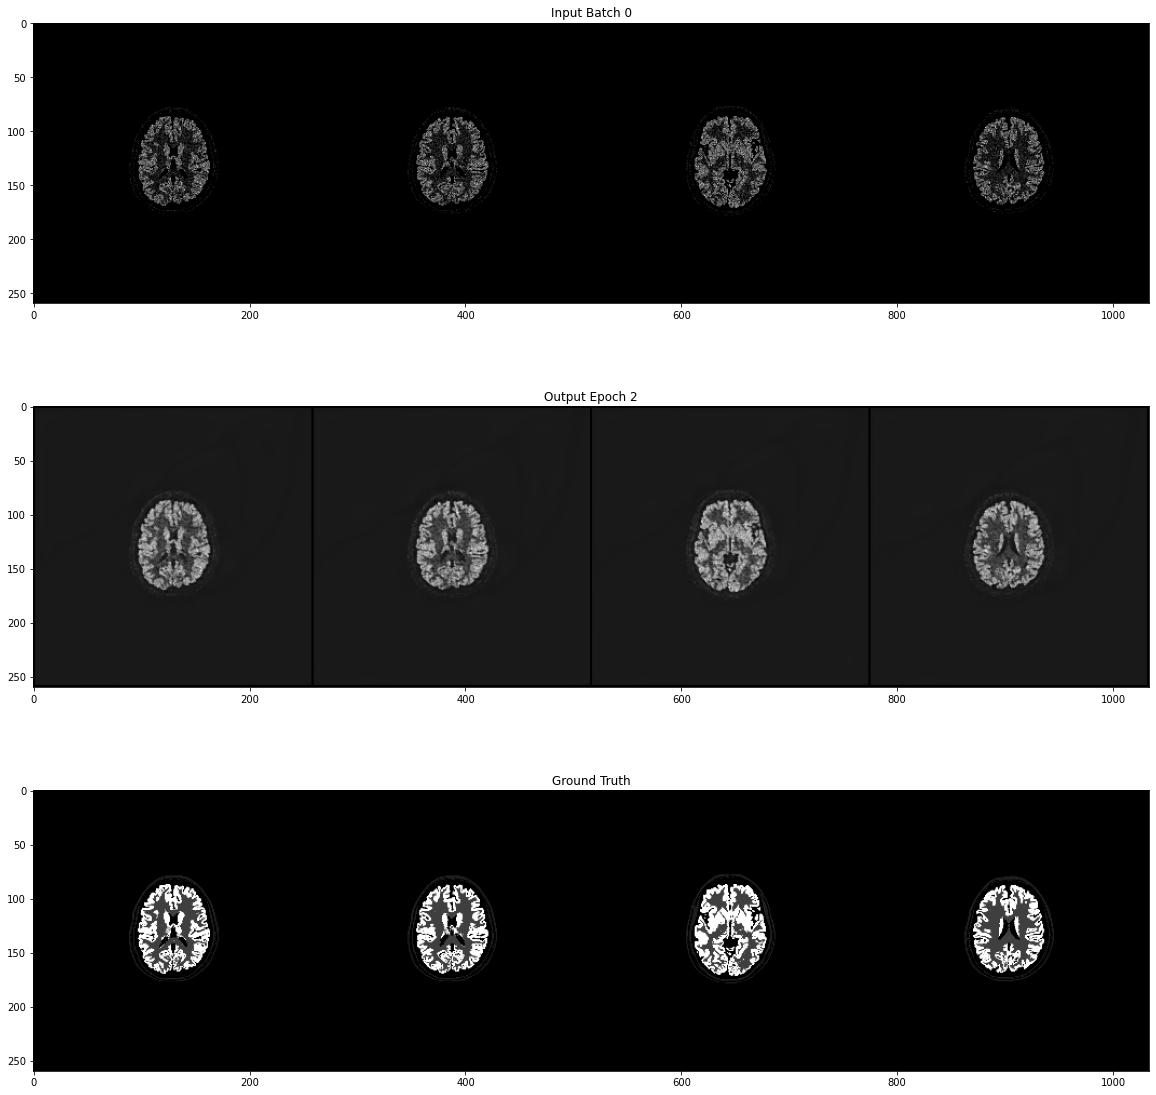

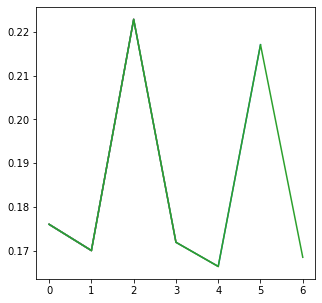

[3,     2] loss: 0.163


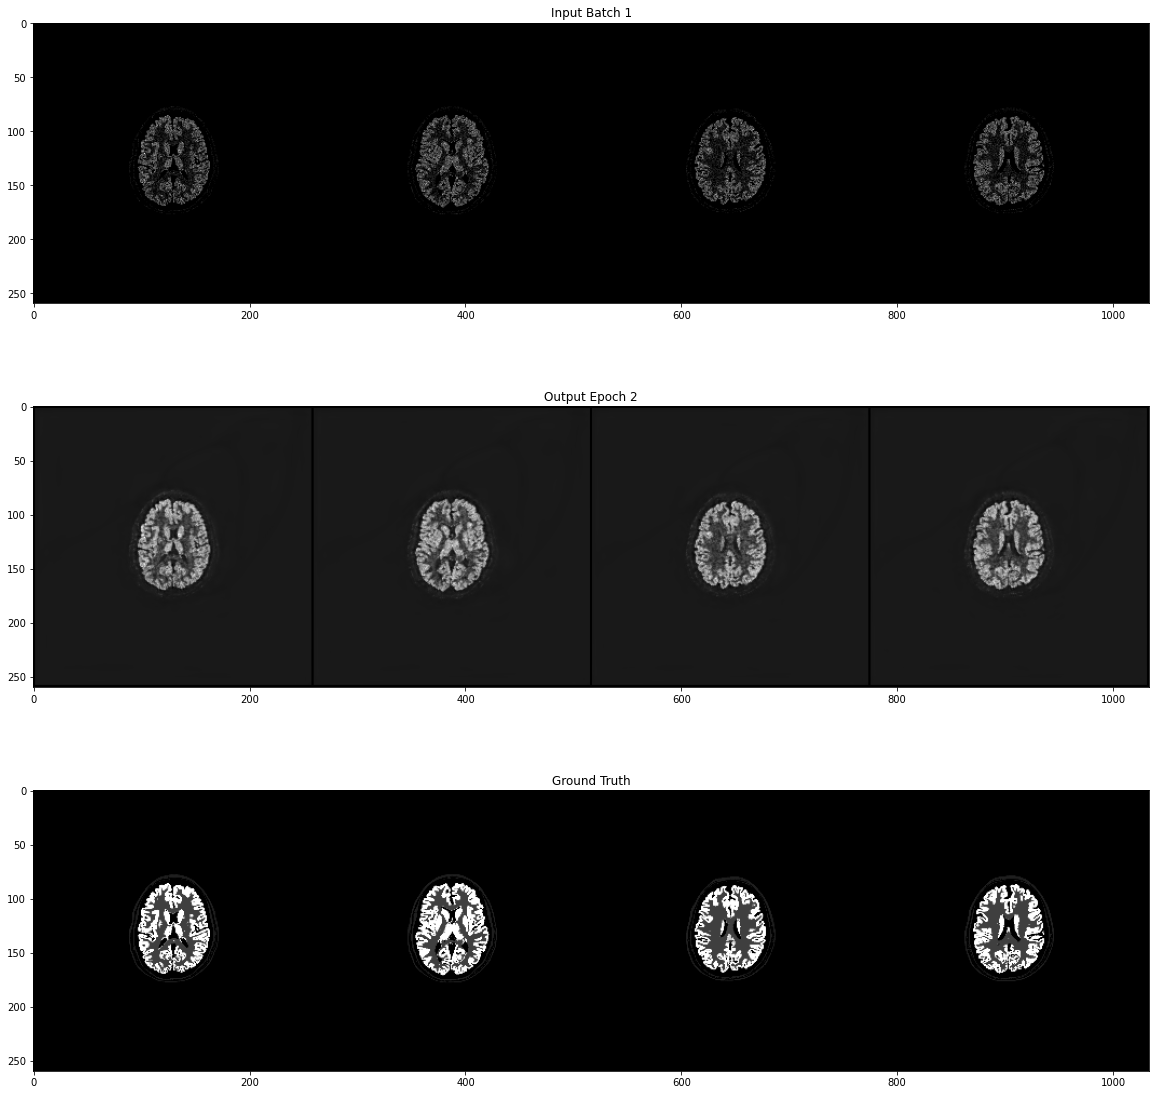

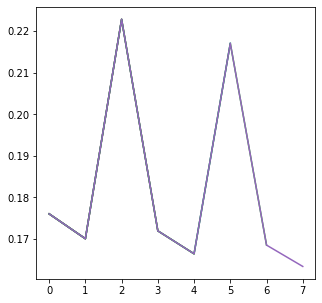

[3,     3] loss: 0.212


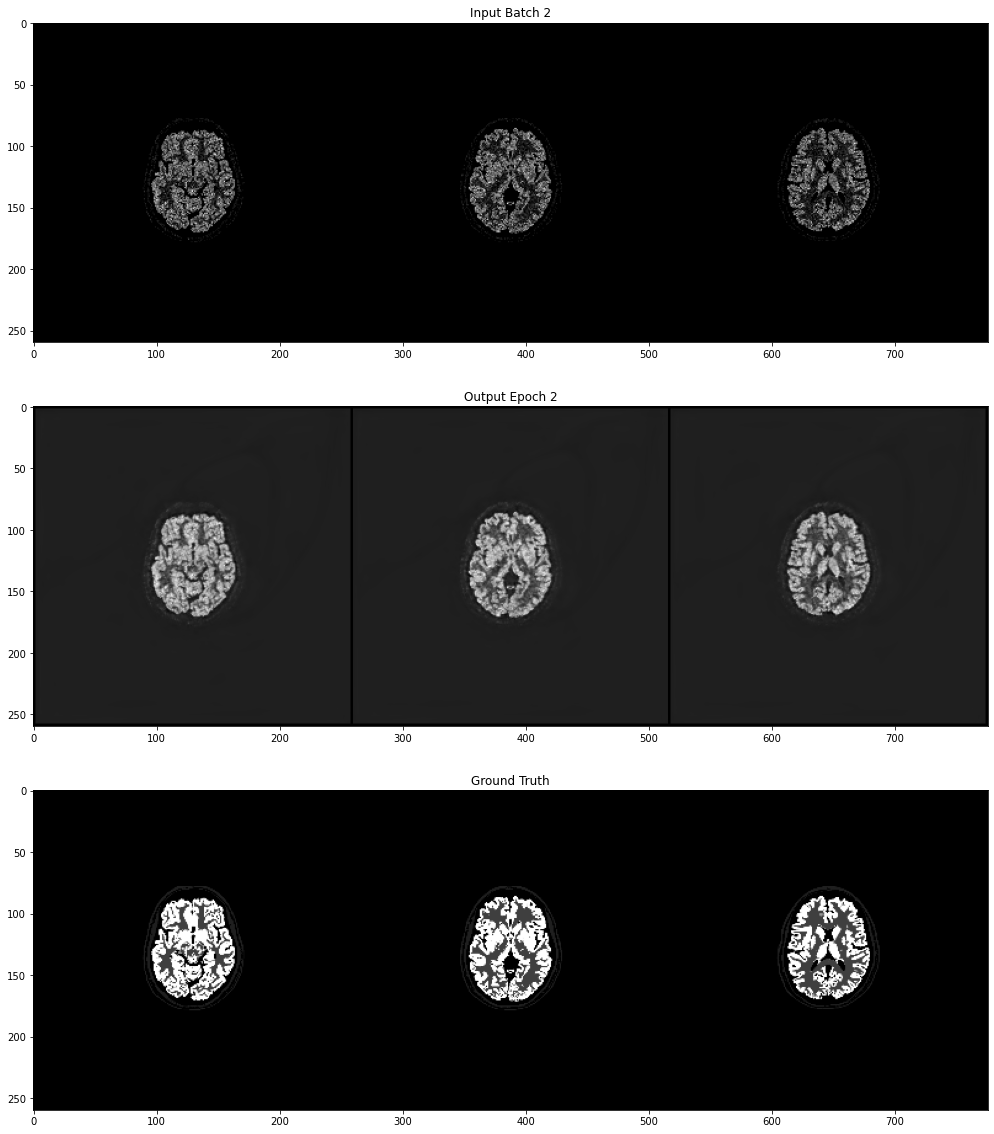

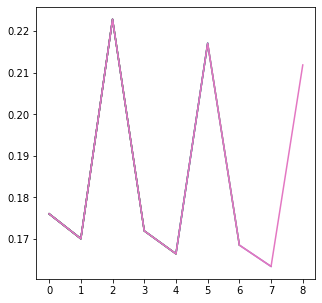

LOSS train 0.21188758313655853 valid 0.1918632537126541
Finished Training


In [72]:
# Codigo entrenamiento Martin 

# defino batches

batchSize = 4
numBatchesTrain = np.round(train_noisyImage.shape[0]/batchSize).astype(int)
numBatchesValid = np.round(valid_noisyImage.shape[0]/batchSize).astype(int)


# Show dev set loss every showDevLossStep batches:
showDevLossStep = 4

printStep = 1
figImages, axs = plt.subplots(3, 1,figsize=(20,20))
figLoss, axLoss = plt.subplots(1, 1,figsize=(5,5))


# Train
loss_values = []
lossValuesTrainingSet = []
iterationNumbers = []
lossValuesDevSet = []
iterationNumbersForDevSet = []

iter = 0

EPOCHS = 3

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    
    unet.train(True)
    for i in range(numBatchesTrain):
        # get the inputs
        
        inputs = torch.from_numpy((train_noisyImage[i*batchSize:(i+1)*batchSize,:,:,:]).astype(np.float32))
        gt = torch.from_numpy((train_groundTruth[i*batchSize:(i+1)*batchSize,:,:,:]).astype(np.float32))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # Save loss values:
        lossValuesTrainingSet.append(loss.item())
        iterationNumbers.append(iter)
     
        if i % printStep == (printStep-1):    # print every printStep mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0
            # Show input images:
            plt.figure(figImages)
            plt.axes(axs[0])
            imshow(torchvision.utils.make_grid(inputs, normalize=True))
            axs[0].set_title('Input Batch {0}'.format(i))
            plt.axes(axs[1])
            imshow(torchvision.utils.make_grid(outputs, normalize=True))
            axs[1].set_title('Output Epoch {0}'.format(epoch))
            plt.axes(axs[2])
            imshow(torchvision.utils.make_grid(gt, normalize=True))
            axs[2].set_title('Ground Truth')
            # Show loss:
            plt.figure(figLoss)
            axLoss.plot(iterationNumbers, lossValuesTrainingSet)
            axLoss.plot(iterationNumbersForDevSet, lossValuesDevSet)
            plt.draw()
            plt.pause(0.0001)
            
            # Update iteration number:
        iter = iter + 1
    
    unet.train(False)
    running_vloss = 0.0
    for i in range(0, numBatchesValid):
        
        vinputs = torch.from_numpy((valid_noisyImage[i*batchSize:(i+1)*batchSize,:,:,:]).astype(np.float32))
        vgt = torch.from_numpy((valid_groundTruth[i*batchSize:(i+1)*batchSize,:,:,:]).astype(np.float32))
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, vgt)
        running_vloss += vloss

        avg_vloss = running_vloss
        print('LOSS train {} valid {}'.format(lossValuesTrainingSet[-1], avg_vloss))
        
        
    

print('Finished Training')

plt.pause(0)

In [73]:
## PRUEBAS ##

# CONJUNTO DE ENTRENAMIENTO

MSE_slice = 5

if __name__ == '__main__':
    inputsTrain = train_noisyImage[MSE_slice]
    inputsTrain = np.expand_dims(inputsTrain, axis=-3)
    inputsTrain = torch.Tensor(inputsTrain)
    outTrain = unet(inputsTrain)
    
gTtrain = train_groundTruth[MSE_slice]
gTtrain = np.expand_dims(gTtrain, axis=-3)
gTtrain = torch.Tensor(gTtrain)

inputsTrain_np = inputsTrain.detach().numpy()
outTrain_np = outTrain.detach().numpy()
gTtrain_np = gTtrain.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])
MSE_test = MSE(outTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])

print('Conjunto de entrenamiento')
print('MSE orig', MSE_orig)
print('MSE UNet', MSE_test)

# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.expand_dims(inputsTest, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims(gTtest, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('Conjunto de testeo')
print('MSE orig', MSE_orig)
print('MSE UNet', MSE_test)



Conjunto de entrenamiento
MSE orig 0.33092233538627625
MSE UNet 0.18278956413269043
Conjunto de testeo
MSE orig 0.361245721578598
MSE UNet 0.18475255370140076


In [ ]:
# Guardar imgs

# Entrenamiento

img_inputs = sitk.GetImageFromArray(inputsTrain_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTrain.nii')

img_out = sitk.GetImageFromArray(outTrain_np[0,0,:,:])
sitk.WriteImage(img_out,'outTrain.nii')

img_gTtest = sitk.GetImageFromArray(gTtrain_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtrain.nii')

# Testeo

img_inputs = sitk.GetImageFromArray(inputsTest_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTest.nii')

img_out = sitk.GetImageFromArray(outTest_np[0,0,:,:])
sitk.WriteImage(img_out,'outTest.nii')

img_gTtest = sitk.GetImageFromArray(gTtest_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtest.nii')

In [75]:
scaleForVisualization = 1.2*gT_np.max()

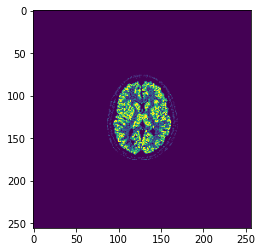

In [76]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

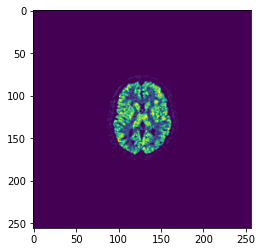

In [77]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )